In [6]:
import os
import numpy as np
import pandas as pd
import scipy.io.wavfile as wav
import scipy.signal as signal
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

%matplotlib notebook

In [7]:
def list_files(directory):
    import os
    
    return [item for item in os.listdir(directory)
            if item.startswith('normal') or \
               item.startswith('extra') or \
               item.startswith('murmur') or \
               item.startswith('artifact')]

In [8]:
def load_data(location):
        contents = list_files(location)
        dataframe = pd.DataFrame(contents, columns=['file_name'])
        
        # assign label to dataframe
        isNormal = lambda x: x.startswith('normal')
        dataframe['normal'] = dataframe['file_name'].apply(isNormal).astype(int)
        
        get_set_name = lambda x: "b" if "set_b" in x else "a"
        
        if not location.endswith('/'):
            location += '/'
        
        dataframe['file_name'] = location + dataframe['file_name']
        dataframe['set_name'] = dataframe['file_name'].apply(get_set_name)
        dataframe['raw_read'] = dataframe['file_name'].apply(wav.read)
        dataframe['sample_frequency'] = dataframe['raw_read'].apply(lambda x: x[0])
        dataframe['wav_file_data'] = dataframe['raw_read'].apply(lambda x: x[1])
        dataframe['data_length'] = dataframe['raw_read'].apply(lambda x: len(x[1]))
        dataframe['seconds'] = dataframe['data_length'] / dataframe['sample_frequency']
        
        return dataframe
        

In [9]:
def shuffle_dataframe(dataframe):
    """
    Shuffles the contents of a pandas dataframe and returns the
    shuffled dataframe
    """
    
    return dataframe.sample(frac=1).reset_index(drop=True)

In [20]:
# Set A is from random people using iStethoscope Pro iPhone app
dataframe_a = load_data('./heartbeat-sounds/set_a')

# Set B is from clinical trial
dataframe_b = load_data('./heartbeat-sounds/set_b')

In [21]:
def get_label_rates(dataframe):
    abnormal_rate = (dataframe['normal'] == 0).astype(int).sum() / len(dataframe['normal'])
    normal_rate = abs(1 - abnormal_rate)
    
    return normal_rate, abnormal_rate

normal_rate, abnormal_rate = get_label_rates(dataframe_b)
print('Normal Rate:', normal_rate, 'Abnormal Rate:', abnormal_rate)

Normal Rate: 0.6941431670281996 Abnormal Rate: 0.30585683297180044


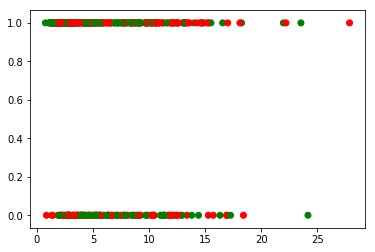

In [22]:
plt.scatter(dataframe_b['seconds'], dataframe_b['normal'], c=['r', 'g'])
plt.show()

In [23]:
example = dataframe_b.iloc[0]
print(example)

file_name           ./heartbeat-sounds/set_b/normal__232_130874852...
normal                                                              1
set_name                                                            b
raw_read            (4000, [474, 596, 374, 53, 69, 182, 136, 208, ...
sample_frequency                                                 4000
wav_file_data       [474, 596, 374, 53, 69, 182, 136, 208, 346, 35...
data_length                                                      6724
seconds                                                         1.681
Name: 0, dtype: object


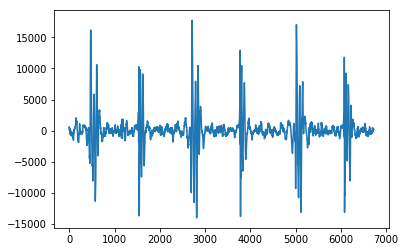

In [24]:
plt.plot(example['wav_file_data'])
plt.show()

In [25]:
examples = len(dataframe_b)
feature_length = max(dataframe_b['data_length'])
X = np.zeros([examples, feature_length])
Y = np.zeros([examples, 1])
Y[:,0] = dataframe_b['normal']

In [26]:
# Copy the data from the pandas array into one numpy matrix
for i in range(len(dataframe_b)):
    wav_file_data = dataframe_b.iloc[i]['wav_file_data']
    length = len(wav_file_data)
    X[i,-length:] = wav_file_data
    
X = np.reshape(X, [examples, 1, feature_length])

In [17]:
def create_model():
    from keras.models import Sequential
    from keras.layers import LSTM, Dense, Activation

    model = Sequential()

    model.add(LSTM(128, input_shape=(1, feature_length), return_sequences=True))
    model.add(LSTM(64, return_sequences=True))
    model.add(LSTM(32))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [18]:
def train_model(model, X_train, Y_train, X_test, Y_test):
    model.fit(X_train, Y_train, epochs=32, validation_data=(X_test, Y_test))

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)
model = create_model()
train_model(model, X_train, Y_train, X_test, Y_test)

Using TensorFlow backend.


Train on 345 samples, validate on 116 samples
Epoch 1/32
345/345 [==============================] - 21s 60ms/step - loss: 0.6902 - acc: 0.6174 - val_loss: 0.6894 - val_acc: 0.6034
Epoch 2/32
345/345 [==============================] - 19s 54ms/step - loss: 0.6813 - acc: 0.7043 - val_loss: 0.6861 - val_acc: 0.6379
Epoch 3/32
345/345 [==============================] - 18s 51ms/step - loss: 0.6715 - acc: 0.7130 - val_loss: 0.6824 - val_acc: 0.6379
Epoch 4/32
345/345 [==============================] - 18s 53ms/step - loss: 0.6576 - acc: 0.7101 - val_loss: 0.6784 - val_acc: 0.6379
Epoch 5/32
345/345 [==============================] - 19s 54ms/step - loss: 0.6399 - acc: 0.7130 - val_loss: 0.6748 - val_acc: 0.6379
Epoch 6/32
345/345 [==============================] - 18s 51ms/step - loss: 0.6147 - acc: 0.7217 - val_loss: 0.6722 - val_acc: 0.6293
Epoch 7/32
345/345 [==============================] - 18s 51ms/step - loss: 0.5790 - acc: 0.7275 - val_loss: 0.6721 - val_acc: 0.6466
Epoch 8/32
345/3

In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation

model = Sequential()

model.add(LSTM(32, input_shape=(1, feature_length)))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [21]:
train_model(model, X_train, Y_train, X_test, Y_test)

Train on 345 samples, validate on 116 samples
Epoch 1/32
345/345 [==============================] - 6s 16ms/step - loss: 0.7330 - acc: 0.5101 - val_loss: 0.7322 - val_acc: 0.4655
Epoch 2/32
345/345 [==============================] - 4s 12ms/step - loss: 0.7153 - acc: 0.5130 - val_loss: 0.7140 - val_acc: 0.5259
Epoch 3/32
345/345 [==============================] - 4s 12ms/step - loss: 0.7041 - acc: 0.5246 - val_loss: 0.7146 - val_acc: 0.5259
Epoch 4/32
345/345 [==============================] - 4s 12ms/step - loss: 0.7013 - acc: 0.5478 - val_loss: 0.7108 - val_acc: 0.5431
Epoch 5/32
345/345 [==============================] - 4s 12ms/step - loss: 0.6964 - acc: 0.5565 - val_loss: 0.7147 - val_acc: 0.5172
Epoch 6/32
345/345 [==============================] - 4s 12ms/step - loss: 0.6938 - acc: 0.5797 - val_loss: 0.7151 - val_acc: 0.5172
Epoch 7/32
345/345 [==============================] - 4s 12ms/step - loss: 0.6942 - acc: 0.5739 - val_loss: 0.7078 - val_acc: 0.5345
Epoch 8/32
345/345 [===

In [23]:
model = Sequential()

model.add(LSTM(32, input_shape=(1, feature_length), return_sequences=True))
model.add(LSTM(32))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
train_model(model, X_train, Y_train, X_test, Y_test)

Train on 345 samples, validate on 116 samples
Epoch 1/32
345/345 [==============================] - 6s 17ms/step - loss: 0.6932 - acc: 0.5130 - val_loss: 0.6883 - val_acc: 0.5517
Epoch 2/32
345/345 [==============================] - 4s 12ms/step - loss: 0.6846 - acc: 0.6145 - val_loss: 0.6806 - val_acc: 0.5862
Epoch 3/32
345/345 [==============================] - 4s 13ms/step - loss: 0.6760 - acc: 0.6667 - val_loss: 0.6749 - val_acc: 0.6207
Epoch 4/32
345/345 [==============================] - 4s 12ms/step - loss: 0.6676 - acc: 0.6986 - val_loss: 0.6717 - val_acc: 0.6293
Epoch 5/32
345/345 [==============================] - 4s 12ms/step - loss: 0.6599 - acc: 0.6957 - val_loss: 0.6679 - val_acc: 0.6466
Epoch 6/32
345/345 [==============================] - 4s 13ms/step - loss: 0.6524 - acc: 0.7072 - val_loss: 0.6641 - val_acc: 0.6552
Epoch 7/32
345/345 [==============================] - 4s 12ms/step - loss: 0.6441 - acc: 0.7072 - val_loss: 0.6606 - val_acc: 0.6466
Epoch 8/32
345/345 [===